In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("LT.NS", start="2022-01-01").reset_index()
df_full.to_csv('LT.csv',index=False)
df_full.head()


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747070,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


In [4]:
df_full.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
516,2024-02-02,3402.699951,3436.350098,3361.000000,3376.050049,3376.050049,7579802
517,2024-02-05,3375.500000,3407.949951,3318.449951,3341.750000,3341.750000,2954238
518,2024-02-06,3346.000000,3427.750000,3337.550049,3424.250000,3424.250000,2545192
519,2024-02-07,3445.000000,3447.000000,3389.000000,3394.699951,3394.699951,2099940
520,2024-02-08,3413.000000,3417.800049,3293.850098,3335.500000,3335.500000,3471257


Text(0.5, 1.0, 'Closing Price')

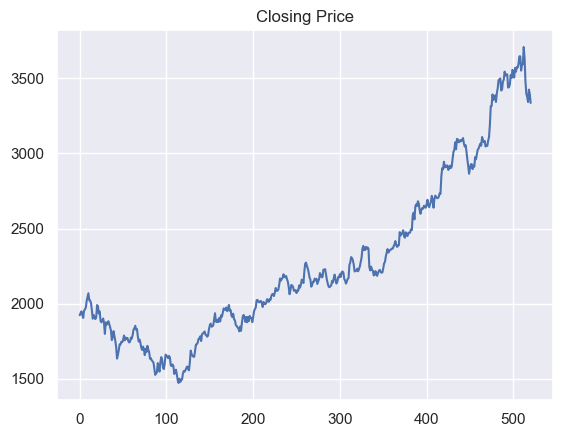

In [5]:
df_full['Close'].plot()
plt.title('Closing Price')

In [6]:
from collections import deque
import random

df= df_full.copy()
name = 'Duel Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations = 400, checkpoint = 20, initial_money = initial_money)

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\soham\AppData\Local\Temp\ipykernel_19944\3888595507.py:28: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
C:\Users\soham\AppData\Local\Temp\ipykernel_19944\3888595507.py:30: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_action = tf.layers.dense(tensor_action, self.action_size)
C:\Users\soham\AppData\Local\Temp\ipykernel_19944\3888595507.py:31: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_validation = tf.layers.dense(tensor_validation, 1)


epoch: 20, total rewards: 2806.699829.3, cost: 0.873433, total money: 12806.699829
epoch: 40, total rewards: 2140.899536.3, cost: 0.005309, total money: 12140.899536
epoch: 60, total rewards: 1988.549927.3, cost: 0.045523, total money: 11988.549927
epoch: 80, total rewards: 1560.399780.3, cost: 0.010518, total money: 11560.399780
epoch: 100, total rewards: 1412.399658.3, cost: 1.849934, total money: 11412.399658
epoch: 120, total rewards: 1852.949707.3, cost: 0.016112, total money: 11852.949707
epoch: 140, total rewards: 1044.099731.3, cost: 0.004191, total money: 11044.099731
epoch: 160, total rewards: 1455.899170.3, cost: 0.005039, total money: 11455.899170
epoch: 180, total rewards: 1055.000000.3, cost: 0.007151, total money: 11055.000000
epoch: 200, total rewards: 1389.550415.3, cost: 0.435773, total money: 11389.550415
epoch: 220, total rewards: 1545.450195.3, cost: 0.029386, total money: 11545.450195
epoch: 240, total rewards: 1284.950317.3, cost: 0.003165, total money: 11284.950

In [8]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 1922.849976, total balance 8077.150024
day 1, sell 1 unit at price 1937.550049, investment 0.764494 %, total balance 10014.700073,
day 8: buy 1 unit at price 2018.400024, total balance 7996.300049
day 9, sell 1 unit at price 2044.750000, investment 1.305488 %, total balance 10041.050049,
day 12: buy 1 unit at price 2020.900024, total balance 8020.150024
day 13, sell 1 unit at price 2003.500000, investment -0.861004 %, total balance 10023.650024,
day 14: buy 1 unit at price 1956.050049, total balance 8067.599976
day 15: buy 1 unit at price 1899.900024, total balance 6167.699951
day 16, sell 1 unit at price 1925.300049, investment -1.572046 %, total balance 8093.000000,
day 17, sell 1 unit at price 1910.849976, investment 0.576344 %, total balance 10003.849976,
day 18: buy 1 unit at price 1897.550049, total balance 8106.299927
day 19, sell 1 unit at price 1909.199951, investment 0.613944 %, total balance 10015.499878,
day 28: buy 1 unit at price 1871.250000, to

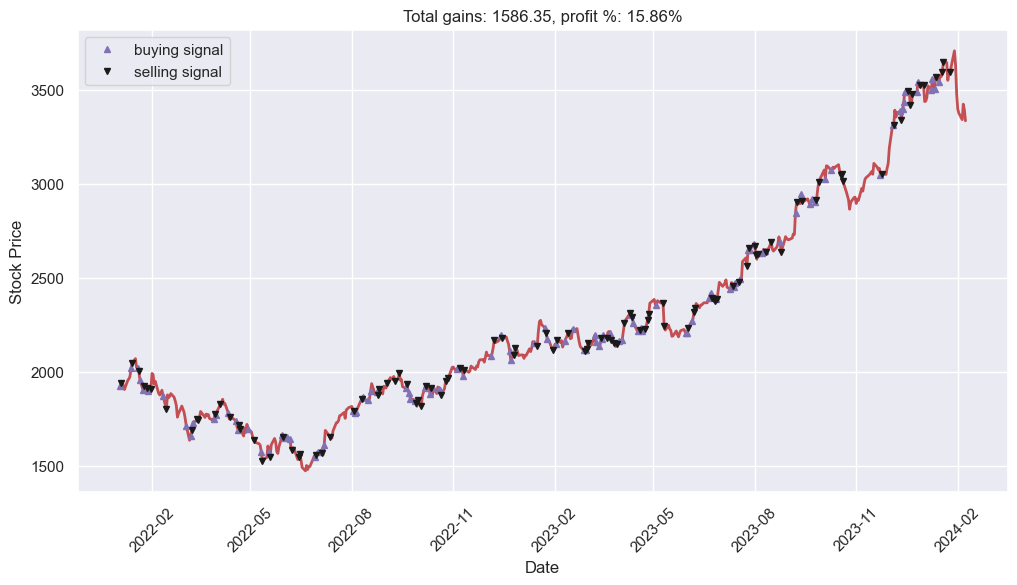

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Load the dataset
df = pd.read_csv('LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=4, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=4, color='k', label='selling signal')

plt.title('Total gains: %.2f, profit %%: %.2f%%' % (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()